# Дисклеймер
Эту тетрадку нужно запускать в колабе или в vast.ai. Не мучайтесь с установкой библиотек и с обучением на cpu.

In [1]:
# !pip install torch torchvision torchaudio
# %pip install pandas scikit-learn matplotlib datasets

## Рекуррентные нейронные сети

Рекуррентные нейронные сети (RNN) предназначены для работы с последовательностями (в том числе текстом). По устройству они похожи на цикл, где каждый шаг связан с предыдущими через внешние переменные, в которые записывается нужная информация по каким-то условиям. Так как в рекуррентных сетях вычисления происходят последовательно, обучение плохо поддается параллелизации. Простыми словами, рекуррентные сети медленные. Но их неэффективность часто компенсируется точностью, поэтому рекуррентные сети - это стандартный инструмент при работе с текстами.

## Классификация текста с помощью RNN

Давайте посмотрим, как в PyTorch использовать рекуррентные слои и как их соединять с Embedding и Linear слоями.

## Код с прошлых занятий

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [4]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

Возьмем небольшой кусок датасета [lenta.ru](https://github.com/yutkin/Lenta.Ru-News-Dataset). Попробуем предсказывать тематику текста

In [6]:
data = pd.read_csv('lenta_40k.csv.zip')

In [7]:
data.head(5)

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [8]:
data.topic.unique()

array(['Спорт', 'Мир', 'Интернет и СМИ', 'Россия', 'Наука и техника',
       'Силовые структуры', 'Бывший СССР', 'Культура', 'Экономика',
       'Ценности', 'Из жизни', 'Дом', 'Бизнес', '69-я параллель', 'Крым',
       'Путешествия', 'Культпросвет ', 'Легпром', 'Библиотека'],
      dtype=object)

Предобработка нам тут особо не важна.

In [9]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

Как и раньше, создаем словарь, фильтруем, чтобы он был адекватного размера и переводим токены в индексы

In [10]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

len(vocab)

354611

In [11]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

len(filtered_vocab)

24091

In [12]:
# индексируем слова
# PAD - для паддинга, UNK - для неизвестных слов
word2id = {'PAD': 0, 'UNK': 1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i: word for word, i in word2id.items()}

In [13]:
# переводим тексты в последовательности индексов
# для слов не из словаря используем индекс UNK
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]  # 1 = UNK
    X.append(ids)

In [14]:
MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN, MEAN_LEN

(1748, np.float64(170.0))

Можно посчитать среднюю или медианную длину, если максимальная кажется слишком большой.

In [15]:
MAX_LEN = int(MEAN_LEN + 30)

In [16]:
MAX_LEN

200

In [17]:
# паддинг - обрезаем или дополняем до MAX_LEN
def pad_sequence(seq, max_len, pad_value=0):
    if len(seq) > max_len:
        return seq[:max_len]
    return seq + [pad_value] * (max_len - len(seq))

X = np.array([pad_sequence(x, MAX_LEN) for x in X])
X.shape

(44356, 200)

In [18]:
id2label = {i: label for i, label in enumerate(set(data.topic.values))}
label2id = {l: i for i, l in id2label.items()}
y = np.array([label2id[label] for label in data.topic.values])
len(label2id)

19

Добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

# конвертируем в тензоры PyTorch
X_train = torch.LongTensor(X_train)
X_valid = torch.LongTensor(X_valid)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

# создаем DataLoader для батчей
BATCH_SIZE = 256
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=BATCH_SIZE, shuffle=False)

Есть несколько разновидностей рекуррентных слоев - RNN (vanilla rnn), GRU, LSTM.

Первый - самый простой рекуррентный слой, где на каждом шаге используется предыдущее состояние и текущий вектор, они складываются и умножаются на матрицу весов с функцией активации, полученный вектор передается на следующий шаг. Проблема с обычными RNN в том, что информация о предыдущих состояниях очень быстро затирается и учитывать нелокальные зависимости не получается.

Можно **схематично** представить Vanilla RNN вот таким циклом в питоне:

In [ ]:
# это вектор внутреннего состояния, можно его рассматривать как память 
hidden_state = [0, 0, ...] 

# ванила рнн это цикл по векторам слов в тексте
for token_vector in text_vectors:
    # на каждом шаге вектор текущего слова складывается с вектором памяти и к ним применяется
    # полносвязный слой и функция активации tanh (гиперболический тангенс)
    # tanh переводит числа в интервал от -1 до 1
    hidden_state = tanh(W(hidden_state + token_vector))

LSTM и GRU частично решают эту проблему добавлением дополнительных матриц весов и активаций, которые будут отвечать за то, чтобы нужная информация сохранялась на протяжении всей последовательности, а ненужная удалялась.

Схематично LSTM можно представить вот так:

In [ ]:
# в LSTM две переменные для памяти (отсюда и название Long-short memory network)
# cell_state используется только внутри ячейки (это long memory)
cell_state = [0, 0, ...]
# а hidden_state также передается наружу (его можно использовать для классификации)
hidden_state = [0, 0, ...]

for token_vector in text_vectors:
    # запоминание/забывание в LSTM реализовано с помощью механизма gate
    # гейт - это полносвязный слой с функцией активации сигмоида (выдает числа от 0 до 1)
    forget_gate = sigmoid(W_forget(hidden_state + token_vector))
    input_gate = sigmoid(W_input(hidden_state + token_vector))
    output_gate = sigmoid(W_output(hidden_state + token_vector))
    
    # 1. forget_gate применяется к cell_state - удаление из долгой памяти
    cell_state_forgotten = forget_gate * cell_state
    
    # 2. в cell_state сохраняется новая информация
    candidate = tanh(W_candidate(hidden_state + token_vector))
    input = candidate * input_gate
    cell_state = cell_state_forgotten + input
    
    # 3. обновляется короткая память (hidden_state)
    hidden_state = tanh(cell_state) * output_gate

А GRU вот так:

In [ ]:
# в GRU только одна переменная для памяти
hidden_state = [0, 0, ...]

for token_vector in text_vectors:
    # В GRU 2 гейта - reset (забывание) и update (запоминание)
    reset = sigmoid(W_reset(token_vector + hidden_state))
    update = sigmoid(W_update(token_vector + hidden_state))
    
    # 1. Из памяти выбирается только нужная информация с помощью reset gate
    candidate_hidden_state = tanh(W_candidate((hidden_state * reset) + token_vector)) 
    
    # 2. update gate решает в какой пропорции совместить память и потенциальный hidden_state
    hidden_state = (update * candidate_hidden_state) + ((1-update) * hidden_state)

На картинке все три типа можно изобразить вот так:

![lstm cell](https://habrastorage.org/webt/xt/_q/nj/xt_qnjgfjengqoqd4gizkq4j_wk.png)

На практике выбор стоит между LSTM и GRU. В LSTM 4 матрицы с весами, а в GRU 3. GRU немного проще (а значит быстрее) LSTM. Но это не значит, что LSTM лучше работает. Лучше пробовать и то и другое.

Ссылки, чтобы разобраться подробнее:  
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/  
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/

Использовать RNN слой в PyTorch достаточно просто. На выходе из vanilla RNN и GRU мы получим `(output, h)`, а на выходе из LSTM - `(output, (h, c))`.
- `output` - скрытые состояния на всех шагах `(batch, seq_len, hidden_size)`
- `h` - последнее скрытое состояние `(num_layers, batch, hidden_size)`

Для классификации используем `h`, так как в нем накоплена вся информация о последовательности.

In [20]:
class TextClassifier(nn.Module):
    
    def __init__(self, vocab_size, emb_dim, hidden_size, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        # все три типа rnn слоев применяются почти одинаково
        # self.rnn = nn.RNN(emb_dim, hidden_size, batch_first=True)
        # self.rnn = nn.GRU(emb_dim, hidden_size, batch_first=True)
        self.rnn = nn.LSTM(emb_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_dim)
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, (h, c) = self.rnn(embedded)  # для GRU/RNN будет (output, h)
        logits = self.fc(h[-1])  # h[-1] - последний слой
        return logits

Схема задачи:

![image](./image_lstm_clf.png)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = TextClassifier(len(word2id), emb_dim=30, hidden_size=128, output_dim=len(label2id))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model

Using device: cuda


TextClassifier(
  (embedding): Embedding(24093, 30, padding_idx=0)
  (rnn): LSTM(30, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=19, bias=True)
)

In [29]:
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

def train_epoch(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = []
    epoch_f1 = []

    pbar = tqdm(iterator, desc="Training", leave=False)

    for texts, labels in pbar:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        preds = predictions.argmax(1).cpu().numpy()
        y_true = labels.cpu().numpy()

        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average='micro'))

        # обновляем прогресс-бар
        pbar.set_postfix(loss=np.mean(epoch_loss), f1=np.mean(epoch_f1))

    return np.mean(epoch_loss), np.mean(epoch_f1)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = []
    epoch_f1 = []

    with torch.no_grad():
        for texts, labels in tqdm(iterator, desc="Evaluating", leave=False):
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts)
            loss = criterion(predictions, labels)

            preds = predictions.argmax(1).cpu().numpy()
            y_true = labels.cpu().numpy()

            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average='micro'))

    return np.mean(epoch_loss), np.mean(epoch_f1)

In [30]:
train_f1s, valid_f1s = [], []

for epoch in range(10):
    train_loss, train_f1 = train_epoch(model, train_loader, optimizer, criterion)
    valid_loss, valid_f1 = evaluate(model, valid_loader, criterion)
    train_f1s.append(train_f1)
    valid_f1s.append(valid_f1)
    print(f'Epoch {epoch+1}: Train F1: {train_f1:.4f} | Valid F1: {valid_f1:.4f}')

Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1: Train F1: 0.7699 | Valid F1: 0.6804


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2: Train F1: 0.7901 | Valid F1: 0.6817


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3: Train F1: 0.8056 | Valid F1: 0.6843


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4: Train F1: 0.8227 | Valid F1: 0.6793


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5: Train F1: 0.8365 | Valid F1: 0.6826


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6: Train F1: 0.8501 | Valid F1: 0.6876


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7: Train F1: 0.8623 | Valid F1: 0.6811


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8: Train F1: 0.8728 | Valid F1: 0.6846


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9: Train F1: 0.8868 | Valid F1: 0.6696


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10: Train F1: 0.8938 | Valid F1: 0.6735


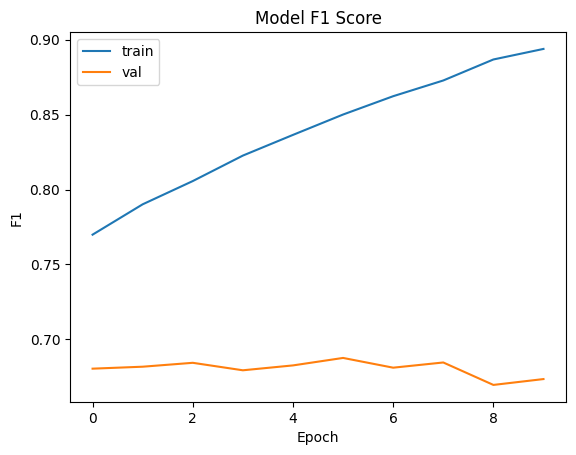

In [31]:
plt.plot(train_f1s)
plt.plot(valid_f1s)
plt.title('Model F1 Score')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Stacked RNN

Рекуррентные слои можно накладывать друг на друга параметром `num_layers`.

In [35]:
class StackedClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size, output_dim, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn = nn.LSTM(emb_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_dim)
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, (h, c) = self.rnn(embedded)
        return self.fc(h[-1])

In [36]:
model = StackedClassifier(len(word2id), 30, 128, len(label2id), num_layers=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_f1s, valid_f1s = [], []

for epoch in range(10):
    train_loss, train_f1 = train_epoch(model, train_loader, optimizer, criterion)
    valid_loss, valid_f1 = evaluate(model, valid_loader, criterion)
    train_f1s.append(train_f1)
    valid_f1s.append(valid_f1)
    print(f'Epoch {epoch+1}: Train F1: {train_f1:.4f} | Valid F1: {valid_f1:.4f}')

Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1: Train F1: 0.2141 | Valid F1: 0.2176


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2: Train F1: 0.2132 | Valid F1: 0.2176


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3: Train F1: 0.2217 | Valid F1: 0.2508


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4: Train F1: 0.2337 | Valid F1: 0.2455


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5: Train F1: 0.2543 | Valid F1: 0.2699


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6: Train F1: 0.2715 | Valid F1: 0.2625


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7: Train F1: 0.2790 | Valid F1: 0.2842


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8: Train F1: 0.2823 | Valid F1: 0.2755


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9: Train F1: 0.2885 | Valid F1: 0.2814


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10: Train F1: 0.3001 | Valid F1: 0.2805


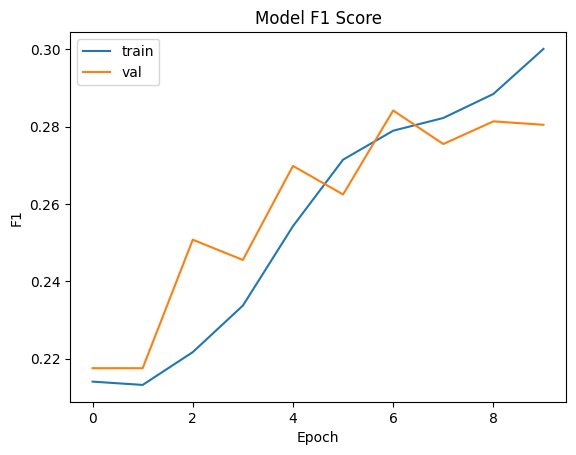

In [37]:
plt.plot(train_f1s)
plt.plot(valid_f1s)
plt.title('Model F1 Score')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Bidirectional RNN

Рекуррентную сеть можно применить в прямом и обратном порядке с `bidirectional=True`.

In [38]:
class BidirectionalClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn = nn.LSTM(emb_dim, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_dim)  # *2 из-за bidirectional
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, (h, c) = self.rnn(embedded)
        # h: (2, batch, hidden_size) для bidirectional
        h_cat = torch.cat([h[0], h[1]], dim=1)
        return self.fc(h_cat)

![bilstm classification](./image_bilstm_clf.png)

In [39]:
model = BidirectionalClassifier(len(word2id), 100, 128, len(label2id)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_f1s, valid_f1s = [], []
for epoch in range(5):
    train_loss, train_f1 = train_epoch(model, train_loader, optimizer, criterion)
    valid_loss, valid_f1 = evaluate(model, valid_loader, criterion)
    train_f1s.append(train_f1)
    valid_f1s.append(valid_f1)
    print(f'Epoch {epoch+1}: Train F1: {train_f1:.4f} | Valid F1: {valid_f1:.4f}')

Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1: Train F1: 0.3069 | Valid F1: 0.4442


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2: Train F1: 0.5250 | Valid F1: 0.5933


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3: Train F1: 0.6389 | Valid F1: 0.6454


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4: Train F1: 0.7037 | Valid F1: 0.6769


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5: Train F1: 0.7473 | Valid F1: 0.6984


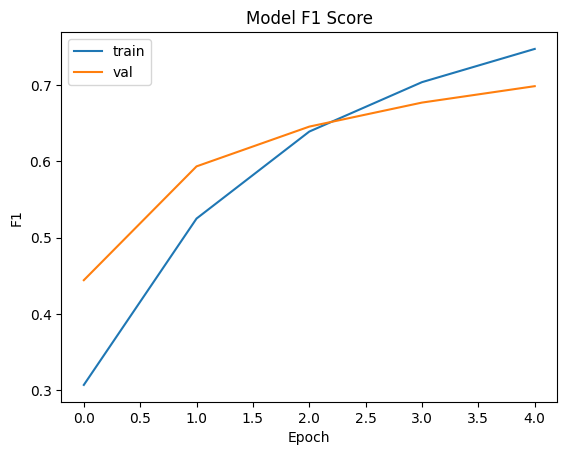

In [40]:
plt.plot(train_f1s)
plt.plot(valid_f1s)
plt.title('Model F1 Score')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

---

# Sequence Labelling

Можно классифицировать каждый элемент последовательности - это называется **sequence labelling**. Под этот паттерн попадает предсказание части речи, определение именованных сущностей, определение опечаток.

Давайте попробуем выделять именованные сущности (NER).

In [41]:
# !pip install datasets
from datasets import load_dataset

Возьмем датасет wikiann для русского языка.

In [45]:
dataset = load_dataset("unimelb-nlp/wikiann", 'ru')
dataset

README.md: 0.00B [00:00, ?B/s]

ru/validation-00000-of-00001.parquet:   0%|          | 0.00/809k [00:00<?, ?B/s]

ru/test-00000-of-00001.parquet:   0%|          | 0.00/816k [00:00<?, ?B/s]

ru/train-00000-of-00001.parquet:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

In [47]:
# Пример данных
dataset['train']['tokens'][0], dataset['train']['ner_tags'][0]

(['Илизаров', ',', 'Гавриил', 'Абрамович'], [1, 2, 2, 2])

Индексы в разметке соответствуют: `['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']`

**PER, ORG, LOC** - типы сущностей: Person, Organization, Location.

**B** - beginning (начало), **I** - inside (внутри), **O** - outside (не-сущность).

Такую разметку называют **IOB** (или BIO).

## Полезная информация о NER

Для извлечения специфичных сущностей придется размечать данные или создавать правила. Для грамматик на русском: [Tomita Parser](https://yandex.ru/dev/tomita/), [Yargy](https://github.com/natasha/yargy). Пример в `NER_rule_based.ipynb`.

**Weak supervision** - разметка с помощью правил для обучения моделей: [Snorkel](https://www.snorkel.org/)

In [48]:
# Создаем словарь для NER
vocab = Counter()
for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

word2id = {'PAD': 0, 'UNK': 1}
for word in vocab:
    word2id[word] = len(word2id)

len(word2id)

36017

In [49]:
def encode_sentences(sentences, word2id):
    return [[word2id.get(w.lower(), 1) for w in sent] for sent in sentences]

def pad_sequences(sequences, max_len, pad_value=0):
    return np.array([seq[:max_len] + [pad_value] * max(0, max_len - len(seq)) for seq in sequences])

X_train = encode_sentences(dataset['train']['tokens'], word2id)
X_test = encode_sentences(dataset['test']['tokens'], word2id)

MAX_LEN = max(len(x) for x in X_train)
X_train = pad_sequences(X_train, MAX_LEN)
X_test = pad_sequences(X_test, MAX_LEN)

In [91]:
# Маппинг тегов wikiann (правильный порядок из датасета)
# 0: O, 1: B-PER, 2: I-PER, 3: B-ORG, 4: I-ORG, 5: B-LOC, 6: I-LOC
id2label = {0: "O", 1: "B-PER", 2: "I-PER", 3: "B-ORG", 4: "I-ORG", 5: "B-LOC", 6: "I-LOC", 7: "PAD"}
label2id = {v: k for k, v in id2label.items()}

# PAD индекс = 7 для ignore_index в CrossEntropyLoss
y_train = pad_sequences(dataset['train']['ner_tags'], MAX_LEN, pad_value=7)
y_test = pad_sequences(dataset['test']['ner_tags'], MAX_LEN, pad_value=7)

X_train.shape, y_train.shape

((20000, 54), (20000, 54))

Схема задачи:

![](image_seq_labelling.png)

In [92]:
X_train_t = torch.LongTensor(X_train)
X_test_t = torch.LongTensor(X_test)
y_train_t = torch.LongTensor(y_train)
y_test_t = torch.LongTensor(y_test)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=128, shuffle=False)

In [97]:
class NERModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size, output_dim, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_dim)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, _ = self.rnn(embedded)
        output = self.dropout(output)
        # используем output (все состояния), а не h
        return self.fc(output)

In [106]:
model = NERModel(len(word2id), 100, 128, len(label2id)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=7)  # игнорируем PAD
optimizer = optim.Adam(model.parameters(), lr=0.001)
model

NERModel(
  (embedding): Embedding(36017, 100, padding_idx=0)
  (dropout): Dropout(p=0.3, inplace=False)
  (rnn): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=8, bias=True)
)

In [107]:
def train_ner(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = []

    pbar = tqdm(iterator, desc="Training", leave=False)

    for texts, labels in pbar:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts).permute(0, 2, 1)  # CrossEntropyLoss expects (batch, classes, seq)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        pbar.set_postfix(loss=np.mean(epoch_loss))

    return np.mean(epoch_loss)

def evaluate_ner(model, iterator, criterion):
    model.eval()
    epoch_loss = []

    with torch.no_grad():
        for texts, labels in tqdm(iterator, desc="Evaluating", leave=False):
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts).permute(0, 2, 1)
            loss = criterion(predictions, labels)

            epoch_loss.append(loss.item())

    return np.mean(epoch_loss)

In [108]:
for epoch in range(15):
    train_loss = train_ner(model, train_loader, optimizer, criterion)
    valid_loss = evaluate_ner(model, test_loader, criterion)
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: Train Loss: 1.0564 | Valid Loss: 0.7592


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.6758 | Valid Loss: 0.5942


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.5805 | Valid Loss: 0.5513


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.5087 | Valid Loss: 0.5145


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.4542 | Valid Loss: 0.4807


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.4114 | Valid Loss: 0.4862


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.3720 | Valid Loss: 0.4700


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.3373 | Valid Loss: 0.4489


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.3036 | Valid Loss: 0.4396


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.2773 | Valid Loss: 0.4417


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.2514 | Valid Loss: 0.4623


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.2316 | Valid Loss: 0.4692


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.2119 | Valid Loss: 0.4944


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.1951 | Valid Loss: 0.4837


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.1780 | Valid Loss: 0.4730


In [109]:
from sklearn.metrics import classification_report

model.eval()
with torch.no_grad():
    pred = model(X_test_t.to(device)).argmax(2).cpu()

print(classification_report(
    y_test_t.reshape(-1).numpy(), 
    pred.reshape(-1).numpy(), 
    labels=list(id2label.keys()),
    target_names=list(id2label.values()),
    zero_division=0
))

              precision    recall  f1-score   support

           O       0.21      0.98      0.35     40480
       B-PER       0.93      0.81      0.86      3543
       I-PER       0.04      0.88      0.07      7544
       B-ORG       0.55      0.61      0.58      4074
       I-ORG       0.04      0.74      0.08      8008
       B-LOC       0.57      0.71      0.63      4559
       I-LOC       0.22      0.70      0.33      3060
         PAD       0.00      0.00      0.00    468732

    accuracy                           0.12    540000
   macro avg       0.32      0.68      0.36    540000
weighted avg       0.03      0.12      0.05    540000



# Предсказание/Inference

In [110]:
import re

def predict_tags(text, word2id, id2label, model, device='cpu'):
    tokens = re.findall(r'\w+|[^\w\s]+', text)
    ids = [word2id.get(t.lower(), 1) for t in tokens]
    
    model.eval()
    with torch.no_grad():
        logits = model(torch.LongTensor([ids]).to(device))
        preds = logits.argmax(2)[0].cpu().tolist()[:len(tokens)]
    
    return list(zip(tokens, [id2label[p] for p in preds]))

In [111]:
model = model.to('cpu')

In [112]:
predict_tags('Алексей сказал Светлане, что поедет в Москву.', word2id, id2label, model)

[('Алексей', 'O'),
 ('сказал', 'O'),
 ('Светлане', 'O'),
 (',', 'O'),
 ('что', 'O'),
 ('поедет', 'O'),
 ('в', 'O'),
 ('Москву', 'B-LOC'),
 ('.', 'O')]

In [113]:
predict_tags('Я поступил в ВШЭ в Питер', word2id, id2label, model)

[('Я', 'O'),
 ('поступил', 'O'),
 ('в', 'O'),
 ('ВШЭ', 'B-LOC'),
 ('в', 'O'),
 ('Питер', 'B-LOC')]